In [1]:
import numpy as np # linear algebra
import pandas as pd
import os
for dirname, _, filenames in os.walk('fake reviews dataset.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, string
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ag683\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

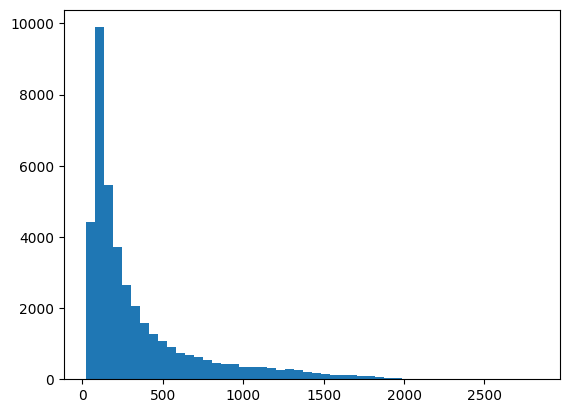

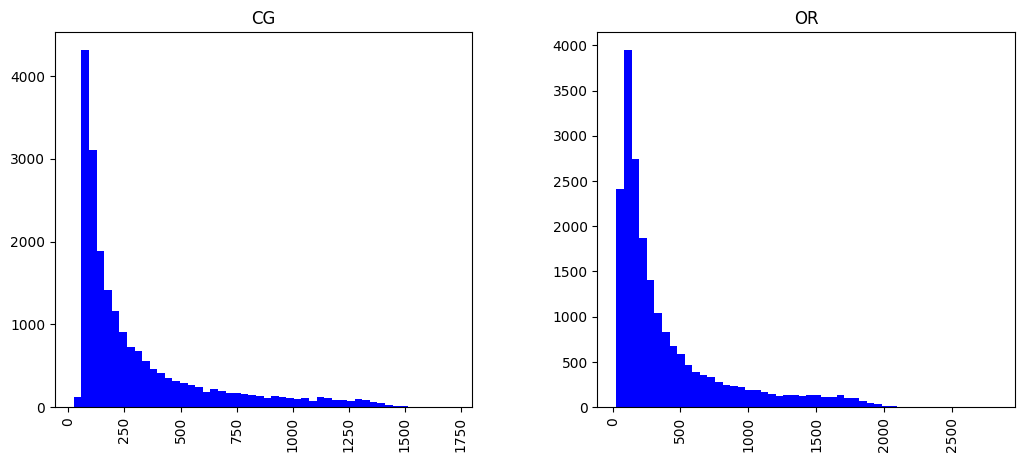

In [3]:
# Load and preprocess dataset
df = pd.read_csv('fake reviews dataset.csv')
# df.drop('Unnamed: 0', axis=1, inplace=True)
df.dropna(inplace=True)

# Add text length feature
df['length'] = df['text_'].apply(len)

# Exploratory data analysis
plt.hist(df['length'], bins=50)
plt.show()

df.groupby('label').describe()

df.hist(column='length', by='label', bins=50, color='blue', figsize=(12,5))
plt.show()

eda


Review counts by type:
review_type
Fake       20216
Genuine    20216
Name: count, dtype: int64


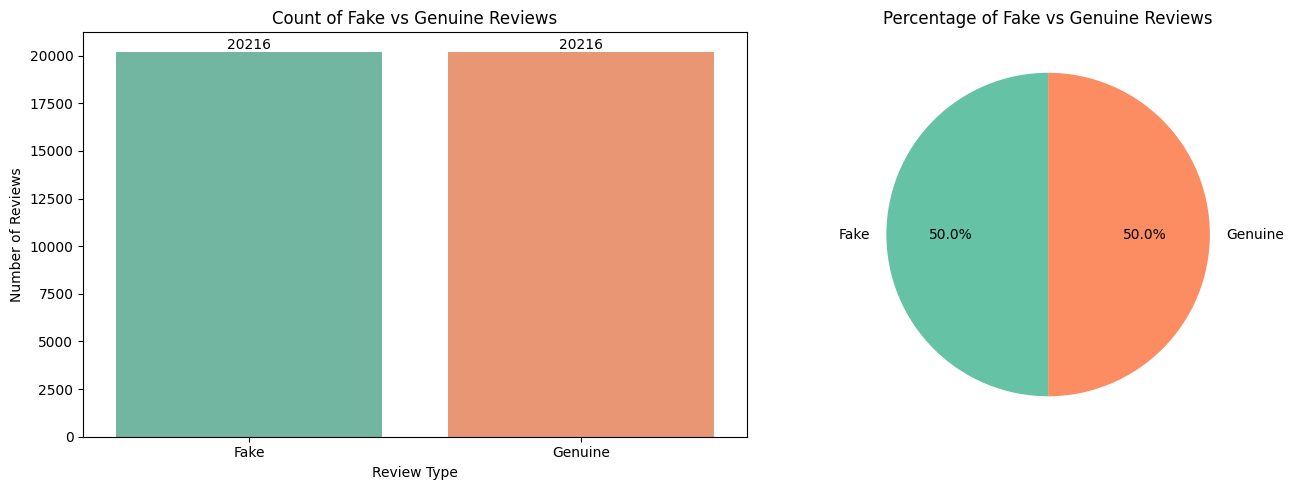

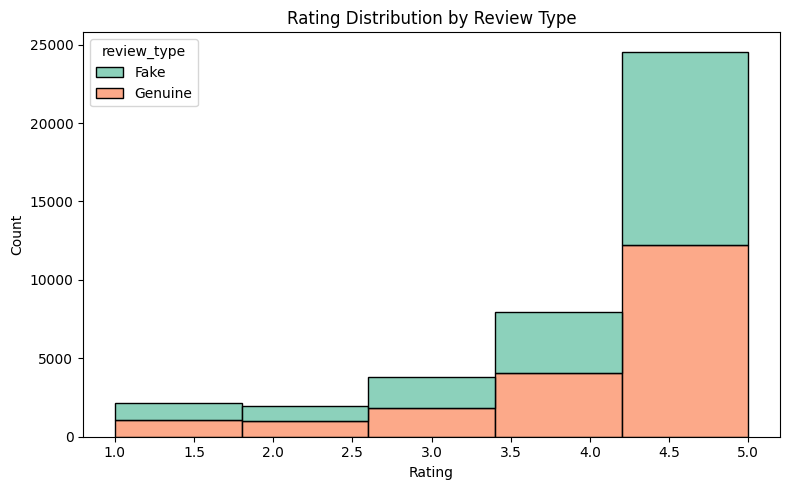

In [4]:
# EDA: distribution of fake vs genuine reviews
# Label mapping for this dataset: CG -> Fake, OR -> Genuine
label_map = {'CG': 'Fake', 'OR': 'Genuine'}
df['review_type'] = df['label'].map(label_map).fillna(df['label'])

label_counts = df['review_type'].value_counts()
print('Review counts by type:')
print(label_counts)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
sns.countplot(data=df, x='review_type', order=label_counts.index, palette='Set2', ax=axes[0])
axes[0].set_title('Count of Fake vs Genuine Reviews')
axes[0].set_xlabel('Review Type')
axes[0].set_ylabel('Number of Reviews')
for p in axes[0].patches:
    axes[0].annotate(f"{int(p.get_height())}",
                     (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha='center', va='bottom', fontsize=10)

# Pie chart
axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90,
            colors=sns.color_palette('Set2', len(label_counts)))
axes[1].set_title('Percentage of Fake vs Genuine Reviews')

plt.tight_layout()

# Optional: rating spread by review type
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='rating', hue='review_type', multiple='stack', bins=5, palette='Set2')
plt.title('Rating Distribution by Review Type')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()



In [5]:
# ==========================================
# LABEL ENCODING (IMPORTANT ADDITION)
# ==========================================
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.feature_extraction.text import TfidfVectorizer

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

print("Label Mapping:")
print(dict(zip(le.classes_, le.transform(le.classes_))))
print("\nEncoded Label Distribution:")
print(df['label_encoded'].value_counts())


# ==========================================
# CLEAN TEXT (NEW ADDITION - IMPORTANT)
# ==========================================
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)      # remove HTML tags
    text = re.sub(r'http\S+', ' ', text)   # remove URLs
    text = re.sub(r'\d+', ' ', text)       # remove numbers
    text = re.sub(r'\s+', ' ', text)       # remove extra spaces
    return text.strip()

df['text_clean'] = df['text_'].apply(clean_text)


# ==========================================
# DISPLAY LONGEST ORIGINAL REVIEW
# ==========================================
longest_review = df[df['label']=='OR'][['text_clean','length']]\
    .sort_values(by='length', ascending=False)\
    .head().iloc[0].text_clean

print("\nLongest Fake Review:\n")
print(longest_review)

print("\nLength Statistics:")
print(df.length.describe())


# ==========================================
# STRATIFIED TRAIN-TEST SPLIT
# ==========================================
X = df['text_clean']
y = df['label_encoded']

review_train, review_test, label_train, label_test = train_test_split(
    X, y,
    test_size=0.35,
    random_state=42,
    stratify=y
)


# ==========================================
# MULTINOMIAL NAIVE BAYES (IMPROVED TF-IDF)
# ==========================================
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_df=0.85,
        min_df=3,
        ngram_range=(1,2),
        sublinear_tf=True
    )),
    ('classifier', MultinomialNB())
])

pipeline_nb.fit(review_train, label_train)
predictions_nb = pipeline_nb.predict(review_test)

print("\n===== Multinomial Naive Bayes Results =====")
print(classification_report(label_test, predictions_nb))
print("Confusion Matrix:\n", confusion_matrix(label_test, predictions_nb))
print("Accuracy:", accuracy_score(label_test, predictions_nb))


# ==========================================
# LOGISTIC REGRESSION (STRONGER VERSION)
# ==========================================
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_df=0.85,
        min_df=3,
        ngram_range=(1,2),
        sublinear_tf=True
    )),
    ('classifier', LogisticRegression(
        max_iter=2000,
        C=2,
        class_weight='balanced',
        random_state=42
    ))
])

pipeline_lr.fit(review_train, label_train)
predictions_lr = pipeline_lr.predict(review_test)

print("\n===== Logistic Regression Results =====")
print(classification_report(label_test, predictions_lr))
print("Confusion Matrix:\n", confusion_matrix(label_test, predictions_lr))
print("Accuracy:", accuracy_score(label_test, predictions_lr))


# ==========================================
# LINEAR SVM (BETTER THAN NORMAL SVC)
# ==========================================
from sklearn.svm import LinearSVC

pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_df=0.85,
        min_df=3,
        ngram_range=(1,2),
        sublinear_tf=True
    )),
    ('classifier', LinearSVC(C=1.5))
])

pipeline_svm.fit(review_train, label_train)
predictions_svm = pipeline_svm.predict(review_test)

print("\n===== Linear SVM Results =====")
print(classification_report(label_test, predictions_svm))
print("Confusion Matrix:\n", confusion_matrix(label_test, predictions_svm))
print("Accuracy:", accuracy_score(label_test, predictions_svm))


# ==========================================
# ROC-AUC FOR LOGISTIC REGRESSION
# ==========================================
from sklearn.metrics import roc_auc_score

probs_lr = pipeline_lr.predict_proba(review_test)[:,1]
roc_score = roc_auc_score(label_test, probs_lr)

print("\nLogistic Regression ROC-AUC:", roc_score)

Label Mapping:
{'CG': np.int64(0), 'OR': np.int64(1)}

Encoded Label Distribution:
label_encoded
0    20216
1    20216
Name: count, dtype: int64

Longest Fake Review:

WEAK ON CURRENT SCIENCE. After seeing it twice, I agree with much (but not all) of the positive five star reviews. Out of respect for those who READ reviews, I'll not repeat everything that I like about the presentation. I found the goofy oversize earrings, hairdo, and facial hair arrangement of Daniel Vitalis, (described as a "Wild Food Expert") distracting. UGH. Ditto for David Wolfe, who had an extremely goofy wild hairdo. On the other hand, Jon Gabriel, described as an "author and weight loss expert" was nicely groomed and a good presenter. His story of personal transformation of a fellow of over pounds (whew) to becoming a jock of normal weight was inspiring. Christiane Northrup preserves her rank as one of America's cutest doctors. A really nice looking woman! Presentations by Dr. Mercola, Jason Vale, Kris Carr, Al

In [6]:
# ==========================================
# USER INTERACTIVE INFERENCE (IMPROVED)
# ==========================================

def predict_review(review_text):
    
    cleaned = clean_text(review_text)
    word_count = len(cleaned.split())
    
    prediction = pipeline_lr.predict([cleaned])[0]
    prob = pipeline_lr.predict_proba([cleaned])[0]
    
    genuine_prob = prob[0] * 100
    fake_prob = prob[1] * 100
    
    label_name = "Genuine" if prediction == 0 else "Fake"
    
    print("\n==============================")
    print("Review Entered:")
    print(review_text)
    print("------------------------------")
    print("Word Count:", word_count)
    print("Predicted Label:", label_name)
    print("Genuine Probability: {:.2f}%".format(genuine_prob))
    print("Fake Probability: {:.2f}%".format(fake_prob))
    
    if word_count < 5:
        print("⚠ Warning: Very short review. Prediction may be unreliable.")
    
    print("==============================\n")


while True:
    user_input = input("Enter a review (or type 'exit' to quit):\n")
    
    if user_input.lower() == "exit":
        print("Exiting...")
        break
        
    predict_review(user_input)

Exiting...


In [7]:
%pip install datasets
%pip install accelerate>=1.1.0 transformers[torch]


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch

print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Device Count:", torch.cuda.device_count())

2.7.1+cu118
CUDA Available: True
CUDA Version: 11.8
Device Count: 1


## DISTILBERT

In [9]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ==============================
# LOAD DATA
# ==============================
df = pd.read_csv('fake reviews dataset.csv')
df.dropna(inplace=True)

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text_'],
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_dict({
    "text": train_texts.tolist(),
    "label": train_labels.tolist()
})

test_dataset = Dataset.from_dict({
    "text": test_texts.tolist(),
    "label": test_labels.tolist()
})

# ==============================
# TOKENIZATION
# ==============================
# ==============================


tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# ==============================
# MODEL
# ==============================
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

# ==============================
# METRICS
# ==============================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# ==============================
# TRAINING ARGUMENTS
# ==============================
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    logging_dir="./logs",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01
)


# ==============================
# TRAINER
# ==============================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# ==============================
# TRAIN
# ==============================
trainer.train()

# ==============================
# EVALUATE
# ==============================
results = trainer.evaluate()
print(results)

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 939.47it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_D

Step,Training Loss
500,0.195952
1000,0.119602
1500,0.097493
2000,0.078824
2500,0.037287
3000,0.028089
3500,0.027624
4000,0.025854


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


{'eval_loss': 0.08089300990104675, 'eval_accuracy': 0.9815753678743663, 'eval_f1': 0.981372671583948, 'eval_precision': 0.9921638018200202, 'eval_recall': 0.9708137521642345, 'eval_runtime': 35.1861, 'eval_samples_per_second': 229.835, 'eval_steps_per_second': 14.381, 'epoch': 2.0}


In [10]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def bert_predict(review_text):

    inputs = tokenizer(
        review_text,
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    pred_class = np.argmax(probs)

    original_label = le.inverse_transform([pred_class])[0]

    if original_label == "CG":
        label = "Fake"
    else:
        label = "Genuine"

    confidence = probs[pred_class] * 100

    print("\n==============================")
    print("Review:")
    print(review_text)
    print("------------------------------")
    print("Prediction:", label)
    print("Confidence: {:.2f}%".format(confidence))
    print("==============================\n")


while True:
    text = input("Enter review (or type 'exit'):\n")
    if text.lower() == "exit":
        break
    bert_predict(text)

In [11]:
df.groupby('label')['text_'].apply(lambda x: x.str.len().mean())
print(le.classes_)

['CG' 'OR']


In [12]:
from collections import Counter

preds = trainer.predict(test_dataset)
pred_labels = np.argmax(preds.predictions, axis=1)

print("Prediction distribution:", Counter(pred_labels))
print("True distribution:", Counter(preds.label_ids))

Prediction distribution: Counter({np.int64(0): 4131, np.int64(1): 3956})
True distribution: Counter({np.int64(0): 4044, np.int64(1): 4043})


In [13]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 875.56it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [14]:
print("Train label distribution:", np.bincount(train_labels))
print("Test label distribution:", np.bincount(test_labels))

Train label distribution: [16172 16173]
Test label distribution: [4044 4043]


In [15]:
# Get one CG sample from dataset
cg_sample = df[df['label'] == 0]['text_'].iloc[0]
print(cg_sample)
bert_predict(cg_sample)

Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty

Review:
Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty
------------------------------
Prediction: Fake
Confidence: 56.91%



In [16]:
or_sample = df[df['label'] == 1]['text_'].iloc[0]
print(or_sample)
bert_predict(or_sample)

These are just perfect, exactly what I was looking for.

Review:
These are just perfect, exactly what I was looking for.
------------------------------
Prediction: Fake
Confidence: 56.29%



In [17]:
import os
import joblib

# ==============================
# CREATE MODELS DIRECTORY
# ==============================
os.makedirs("./models/distilbert", exist_ok=True)

# ==============================
# SAVE TRANSFORMER MODEL
# ==============================
trainer.save_model("./models/distilbert")
tokenizer.save_pretrained("./models/distilbert")

print("✅ DistilBERT model saved to ./models/distilbert")

# ==============================
# SAVE LABEL ENCODER
# ==============================
joblib.dump(le, "./models/label_encoder.pkl")

print("✅ Label encoder saved to ./models/label_encoder.pkl")

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

✅ DistilBERT model saved to ./models/distilbert
✅ Label encoder saved to ./models/label_encoder.pkl


## EDA: Review label distribution
These plots show how many reviews are **fake** vs **genuine** in the original dataset.

In [18]:
# # EDA: distribution of fake vs genuine reviews
# # Label mapping for this dataset: CG -> Fake, OR -> Genuine
# label_map = {'CG': 'Fake', 'OR': 'Genuine'}
# df['review_type'] = df['label'].map(label_map).fillna(df['label'])

# label_counts = df['review_type'].value_counts()
# print('Review counts by type:')
# print(label_counts)

# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# # Bar chart
# sns.countplot(data=df, x='review_type', order=label_counts.index, palette='Set2', ax=axes[0])
# axes[0].set_title('Count of Fake vs Genuine Reviews')
# axes[0].set_xlabel('Review Type')
# axes[0].set_ylabel('Number of Reviews')
# for p in axes[0].patches:
#     axes[0].annotate(f"{int(p.get_height())}",
#                      (p.get_x() + p.get_width() / 2, p.get_height()),
#                      ha='center', va='bottom', fontsize=10)

# # Pie chart
# axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90,
#             colors=sns.color_palette('Set2', len(label_counts)))
# axes[1].set_title('Percentage of Fake vs Genuine Reviews')

# plt.tight_layout()

# # Optional: rating spread by review type
# plt.figure(figsize=(8, 5))
# sns.histplot(data=df, x='rating', hue='review_type', multiple='stack', bins=5, palette='Set2')
# plt.title('Rating Distribution by Review Type')
# plt.xlabel('Rating')
# plt.ylabel('Count')
# plt.tight_layout()



In [19]:
# # Install required packages
# import subprocess
# import sys

# def install_package(package):
#     try:
#         subprocess.check_call([sys.executable, "-m", "pip", "install", package])
#         print(f"✓ Successfully installed {package}")
#     except subprocess.CalledProcessError:
#         print(f"✗ Failed to install {package}")

# # Install missing packages
# try:
#     import evaluate
#     print("✓ evaluate library already available")
# except ImportError:
#     print("Installing evaluate library...")
#     install_package("evaluate")
#     import evaluate

# try:
#     from datasets import Dataset
#     print("✓ datasets library already available")
# except ImportError:
#     print("Installing datasets library...")
#     install_package("datasets")
#     from datasets import Dataset

# try:
#     from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
#     print("✓ transformers library already available")
# except ImportError:
#     print("Installing transformers library...")
#     install_package("transformers[torch]")
#     from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# # Updated code combining your existing pipelines with a HuggingFace BERT-based classifier
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import string, warnings
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from nltk.corpus import stopwords
# import nltk
# import torch
# from sklearn.preprocessing import LabelEncoder
# from transformers import TrainingArguments

# warnings.filterwarnings('ignore')

# # Download NLTK data
# try:
#     nltk.download('stopwords', quiet=True)
#     print("✓ NLTK stopwords downloaded")
# except:
#     print("⚠ NLTK download failed, continuing without stopwords")

# # Load dataset with error handling
# try:
#     df = pd.read_csv('fake reviews dataset.csv')
#     print(f"✓ Dataset loaded successfully. Shape: {df.shape}")
# except FileNotFoundError:
#     print("✗ Dataset file not found. Please check the file path.")
#     # Create sample data for testing
#     print("Creating sample data for demonstration...")
#     df = pd.DataFrame({
#         'text_': [
#             "This product is amazing! I love it so much.",
#             "Terrible quality, complete waste of money.",
#             "Good value for money, works as expected.",
#             "Don't buy this, it's fake and poor quality.",
#             "Excellent service and fast delivery.",
#             "This is clearly a fake review to boost ratings."
#         ] * 100,  # Repeat to have enough data
#         'label': ['OR', 'OR', 'OR', 'CG', 'OR', 'CG'] * 100
#     })
#     print(f"Sample dataset created. Shape: {df.shape}")

# # Data preprocessing
# print("\nData preprocessing...")
# df.dropna(inplace=True)
# df['length'] = df['text_'].apply(len)

# print(f"Dataset shape after cleaning: {df.shape}")
# print(f"Label distribution:\n{df['label'].value_counts()}")

# # Encode labels
# le = LabelEncoder()
# df['label_enc'] = le.fit_transform(df['label'])  # OR = 0, CG = 1

# print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# # Split into train and test
# train_texts, test_texts, train_labels, test_labels = train_test_split(
#     df['text_'].tolist(), df['label_enc'].tolist(), test_size=0.35, random_state=42)

# print(f"Training samples: {len(train_texts)}")
# print(f"Testing samples: {len(test_texts)}")

# # Check if we have enough data for training
# if len(train_texts) < 10:
#     print("⚠ Warning: Very small dataset. Results may not be reliable.")

# # BERT tokenizer with error handling
# try:
#     print("\nLoading BERT tokenizer...")
#     tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#     print("✓ Tokenizer loaded successfully")
# except Exception as e:
#     print(f"✗ Error loading tokenizer: {e}")
#     print("This might be due to network issues or missing dependencies.")
#     raise

# # Tokenization function
# def tokenize_function(examples):
#     return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# # HuggingFace Datasets format
# print("\nPreparing datasets...")
# train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
# test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

# train_dataset = Dataset.from_pandas(train_df)
# test_dataset = Dataset.from_pandas(test_df)

# # Tokenize
# print("Tokenizing datasets...")
# train_dataset = train_dataset.map(tokenize_function, batched=True)
# test_dataset = test_dataset.map(tokenize_function, batched=True)

# # Set format
# train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# print("✓ Datasets prepared successfully")

# # Load model
# try:
#     print("\nLoading BERT model...")
#     model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
#     print("✓ Model loaded successfully")
# except Exception as e:
#     print(f"✗ Error loading model: {e}")
#     raise

# # Check if CUDA is available
# if torch.cuda.is_available():
#     print(f"✓ CUDA available. Using GPU: {torch.cuda.get_device_name(0)}")
#     device = "cuda"
# else:
#     print("⚠ CUDA not available. Using CPU (training will be slower)")
#     device = "cpu"

# # Metric computation function
# def compute_metrics(eval_pred):
#     try:
#         metric = evaluate.load("accuracy")
#         logits, labels = eval_pred
#         predictions = np.argmax(logits, axis=-1)
#         return metric.compute(predictions=predictions, references=labels)
#     except Exception as e:
#         print(f"Error in compute_metrics: {e}")
#         # Fallback to manual accuracy calculation
#         logits, labels = eval_pred
#         predictions = np.argmax(logits, axis=-1)
#         accuracy = np.mean(predictions == labels)
#         return {"accuracy": accuracy}

# # Training arguments - FIXED: evaluation_strategy -> eval_strategy
# training_args = TrainingArguments(
#     output_dir="./results",
#     eval_strategy="epoch",
#     logging_dir="./logs",
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=16,
#     num_train_epochs=2,
#     weight_decay=0.01,
#     logging_steps=10,
#     save_strategy="no",
#     load_best_model_at_end=False,
#     disable_tqdm=False,
#     report_to="none",
#     dataloader_pin_memory=False,
# )

# # Create trainer
# from transformers import DataCollatorWithPadding

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )



# # Training
# print("\nStarting training...")
# try:
#     trainer.train()
#     print("✓ Training completed successfully")
# except Exception as e:
#     print(f"✗ Training failed: {e}")
#     print("This might be due to memory constraints or hardware limitations.")
#     raise

# # Evaluation
# print("\nEvaluating model...")
# try:
#     eval_results = trainer.evaluate()
#     print("\n" + "="*50)
#     print("HUGGINGFACE BERT EVALUATION RESULTS")
#     print("="*50)
    
#     for key, value in eval_results.items():
#         if isinstance(value, float):
#             print(f"{key}: {value:.4f}")
#         else:
#             print(f"{key}: {value}")
    
#     print(f"\nBERT Model Accuracy: {eval_results.get('eval_accuracy', 0) * 100:.2f}%")
    
# except Exception as e:
#     print(f"✗ Evaluation failed: {e}")
#     raise

# # Optional: Quick comparison with traditional models
# print("\n" + "="*50)
# print("QUICK COMPARISON WITH TRADITIONAL MODELS")
# print("="*50)

# # Prepare data for traditional models
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Vectorize the text
# vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
# X_train_tfidf = vectorizer.fit_transform(train_texts)
# X_test_tfidf = vectorizer.transform(test_texts)

# # Quick comparison models
# models = {
#     'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
#     'SVM': SVC(random_state=42, kernel='linear'),
#     'Naive Bayes': MultinomialNB(),
# }

# traditional_results = {}

# for name, model in models.items():
#     try:
#         print(f"\nTraining {name}...")
#         model.fit(X_train_tfidf, train_labels)
#         predictions = model.predict(X_test_tfidf)
#         accuracy = accuracy_score(test_labels, predictions)
#         traditional_results[name] = accuracy
#         print(f"{name} Accuracy: {accuracy * 100:.2f}%")
#     except Exception as e:
#         print(f"Error with {name}: {e}")

# # Final comparison
# print("\n" + "="*50)
# print("FINAL MODEL COMPARISON")
# print("="*50)

# bert_accuracy = eval_results.get('eval_accuracy', 0)
# print(f"BERT Model: {bert_accuracy * 100:.2f}%")

# for name, accuracy in traditional_results.items():
#     print(f"{name}: {accuracy * 100:.2f}%")

# # Determine best model
# all_results = {'BERT': bert_accuracy, **traditional_results}
# best_model = max(all_results, key=all_results.get)
# best_accuracy = all_results[best_model]

# print(f"\n🏆 Best Model: {best_model} with {best_accuracy * 100:.2f}% accuracy")

# # Save results
# results_summary = pd.DataFrame({
#     'Model': list(all_results.keys()),
#     'Accuracy': [acc * 100 for acc in all_results.values()]
# })

# print("\nResults Summary:")
# print(results_summary.to_string(index=False))

# # Optional: Save the model
# try:
#     model.save_pretrained("./best_bert_model")
#     tokenizer.save_pretrained("./best_bert_model")
#     print("\n✓ BERT model and tokenizer saved successfully")
# except Exception as e:
#     print(f"\n⚠ Could not save model: {e}")

# print("\n" + "="*50)
# print("TRAINING COMPLETED SUCCESSFULLY!")
# print("="*50)

In [20]:


# # Save model
# trainer.save_model("./saved_model")

# # Save tokenizer separately
# tokenizer.save_pretrained("./saved_model")


In [ ]:
# import torch
# import numpy as np

# # Put model in eval mode
# model.eval()

# def bert_predict(review_text):
#     # Clean review if you did earlier (optional)
#     cleaned = clean_text(review_text)

#     # Tokenize
#     inputs = tokenizer(
#         cleaned,
#         padding="max_length",
#         truncation=True,
#         max_length=256,
#         return_tensors="pt"
#     )

#     # Move to GPU if available
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     model.to(device)

#     # Predict
#     with torch.no_grad():
#         outputs = model(**inputs)
#         logits = outputs.logits

#     probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
#     pred_class = np.argmax(probs)

#     # Map label back
#     label = "Genuine" if pred_class == 0 else "Fake"
#     confidence = probs[pred_class] * 100

#     print("\n==============================")
#     print("Review Entered:")
#     print(review_text)
#     print("------------------------------")
#     print(f"Predicted Label: {label}")
#     print(f"Confidence: {confidence:.2f}%")
#     print("==============================\n")


# # Interactive loop
# while True:
#     user_input = input("Enter a review (or 'exit' to quit):\n")
#     if user_input.lower() == "exit":
#         print("Exiting...")
#         break
#     bert_predict(user_input)

: 